# Lecture 1 - Jet tagging with neural networks

> A first look at training deep neural networks to classify jets in proton-proton collisions.

## Learning objectives

* Understand what jet tagging is and how to frame it as a machine learning task
* Understand the main steps needed to train and evaluate a jet tagger
* Gain an introduction to the fastai library

## References

* Chapter 1 of [_Deep Learning for Coders with fastai & PyTorch_](https://github.com/fastai/fastbook) by Jeremy Howard and Sylvain Gugger.
* [_The Machine Learning Landscape of Top Taggers_](https://arxiv.org/abs/1902.09914) by G. Kasieczka et al.
* [_How Much Information is in a Jet?_](https://arxiv.org/abs/1704.08249) by K. Datta and A. Larkowski.

## The task and data

For the first few lectures, we'll be analysing the [_Top Quark Tagging_ dataset](https://huggingface.co/datasets/top-landscape/top_quark_tagging), which is a famous benchmark that's used to compare the performance of jet classification algorithms. The dataset consists of around 2 million Monte Carlo simulated events in proton-proton collisions that have been clustered into jets.

Framed as a supervised machine learning task, the goal is to train a model that can classify each jet as either a top-quark signal or quark-gluon background.

```{figure} ./images/jet-tagging.png
---
scale: 100%
name: jet-tagging
---
Figure reference: [Particle Transformer for Jet Tagging](https://arxiv.org/abs/2202.03772)
```

## Setup

In [ ]:
# Uncomment and run this cell if using Colab, Kaggle etc
# %pip install fastai==2.5.6 datasets

In [ ]:
# Check we have the correct fastai version
import fastai

assert fastai.__version__ == "2.5.6"

## Import libraries

In [1]:
from datasets import load_dataset
from fastai.tabular.all import *
from scipy.interpolate import interp1d
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

In [2]:
import datasets

# Suppress logs
datasets.logging.set_verbosity_error()

## Getting the data

We will use the [🤗 Datasets](https://github.com/huggingface/datasets) library to download and process the datasets that we'll encounter in this course. 🤗 Datasets provides smart caching and allows you to process larger-than-RAM datasets by exploiting a technique called _memory-mapping_ that provides a mapping between RAM and filesystem storage.

To download the Top Quark Tagging dataset from the [Hugging Face Hub](https://huggingface.co/datasets/top-landscape/top_quark_tagging), we can use the `load_dataset()` function:

In [3]:
top_quark_ds = load_dataset("top-landscape/top_quark_tagging")

  0%|          | 0/3 [00:00<?, ?it/s]

If we look inside our `top_quark_ds` object

In [4]:
top_quark_ds

DatasetDict({
    train: Dataset({
        features: ['E_0', 'PX_0', 'PY_0', 'PZ_0', 'E_1', 'PX_1', 'PY_1', 'PZ_1', 'E_2', 'PX_2', 'PY_2', 'PZ_2', 'E_3', 'PX_3', 'PY_3', 'PZ_3', 'E_4', 'PX_4', 'PY_4', 'PZ_4', 'E_5', 'PX_5', 'PY_5', 'PZ_5', 'E_6', 'PX_6', 'PY_6', 'PZ_6', 'E_7', 'PX_7', 'PY_7', 'PZ_7', 'E_8', 'PX_8', 'PY_8', 'PZ_8', 'E_9', 'PX_9', 'PY_9', 'PZ_9', 'E_10', 'PX_10', 'PY_10', 'PZ_10', 'E_11', 'PX_11', 'PY_11', 'PZ_11', 'E_12', 'PX_12', 'PY_12', 'PZ_12', 'E_13', 'PX_13', 'PY_13', 'PZ_13', 'E_14', 'PX_14', 'PY_14', 'PZ_14', 'E_15', 'PX_15', 'PY_15', 'PZ_15', 'E_16', 'PX_16', 'PY_16', 'PZ_16', 'E_17', 'PX_17', 'PY_17', 'PZ_17', 'E_18', 'PX_18', 'PY_18', 'PZ_18', 'E_19', 'PX_19', 'PY_19', 'PZ_19', 'E_20', 'PX_20', 'PY_20', 'PZ_20', 'E_21', 'PX_21', 'PY_21', 'PZ_21', 'E_22', 'PX_22', 'PY_22', 'PZ_22', 'E_23', 'PX_23', 'PY_23', 'PZ_23', 'E_24', 'PX_24', 'PY_24', 'PZ_24', 'E_25', 'PX_25', 'PY_25', 'PZ_25', 'E_26', 'PX_26', 'PY_26', 'PZ_26', 'E_27', 'PX_27', 'PY_27', 'PZ_27', 'E_28'

we see it is similar to a Python dictionary, with each key corresponding to a different split. And we can use the usual dictionary syntax to access an individual split:

In [4]:
train_ds = top_quark_ds["train"]
train_ds

Dataset({
    features: ['E_0', 'PX_0', 'PY_0', 'PZ_0', 'E_1', 'PX_1', 'PY_1', 'PZ_1', 'E_2', 'PX_2', 'PY_2', 'PZ_2', 'E_3', 'PX_3', 'PY_3', 'PZ_3', 'E_4', 'PX_4', 'PY_4', 'PZ_4', 'E_5', 'PX_5', 'PY_5', 'PZ_5', 'E_6', 'PX_6', 'PY_6', 'PZ_6', 'E_7', 'PX_7', 'PY_7', 'PZ_7', 'E_8', 'PX_8', 'PY_8', 'PZ_8', 'E_9', 'PX_9', 'PY_9', 'PZ_9', 'E_10', 'PX_10', 'PY_10', 'PZ_10', 'E_11', 'PX_11', 'PY_11', 'PZ_11', 'E_12', 'PX_12', 'PY_12', 'PZ_12', 'E_13', 'PX_13', 'PY_13', 'PZ_13', 'E_14', 'PX_14', 'PY_14', 'PZ_14', 'E_15', 'PX_15', 'PY_15', 'PZ_15', 'E_16', 'PX_16', 'PY_16', 'PZ_16', 'E_17', 'PX_17', 'PY_17', 'PZ_17', 'E_18', 'PX_18', 'PY_18', 'PZ_18', 'E_19', 'PX_19', 'PY_19', 'PZ_19', 'E_20', 'PX_20', 'PY_20', 'PZ_20', 'E_21', 'PX_21', 'PY_21', 'PZ_21', 'E_22', 'PX_22', 'PY_22', 'PZ_22', 'E_23', 'PX_23', 'PY_23', 'PZ_23', 'E_24', 'PX_24', 'PY_24', 'PZ_24', 'E_25', 'PX_25', 'PY_25', 'PZ_25', 'E_26', 'PX_26', 'PY_26', 'PZ_26', 'E_27', 'PX_27', 'PY_27', 'PZ_27', 'E_28', 'PX_28', 'PY_28', 'PZ_28', 

The `Dataset` object is one of the core data structures in 🤗 Datasets and behaves like an ordinary Python `list`, so we can query its length:

In [6]:
len(train_ds)

1211000

or access a single element by its index:

In [7]:
train_ds[0]

{'E_0': 474.0711364746094,
 'PX_0': -250.34703063964844,
 'PY_0': -223.65196228027344,
 'PZ_0': -334.73809814453125,
 'E_1': 103.23623657226562,
 'PX_1': -48.8662223815918,
 'PY_1': -56.790775299072266,
 'PZ_1': -71.0254898071289,
 'E_2': 105.25556945800781,
 'PX_2': -55.415000915527344,
 'PY_2': -49.96888732910156,
 'PZ_2': -74.23626708984375,
 'E_3': 40.17677688598633,
 'PX_3': -21.760696411132812,
 'PY_3': -18.71761131286621,
 'PZ_3': -28.112215042114258,
 'E_4': 22.4285831451416,
 'PX_4': -11.835756301879883,
 'PY_4': -10.374107360839844,
 'PZ_4': -15.979177474975586,
 'E_5': 20.334388732910156,
 'PX_5': -10.950518608093262,
 'PY_5': -9.545439720153809,
 'PZ_5': -14.228776931762695,
 'E_6': 19.030899047851562,
 'PX_6': -10.243264198303223,
 'PY_6': -9.004837036132812,
 'PZ_6': -13.272662162780762,
 'E_7': 13.460596084594727,
 'PX_7': -7.3433637619018555,
 'PY_7': -6.359743595123291,
 'PZ_7': -9.317526817321777,
 'E_8': 11.226107597351074,
 'PX_8': -5.981515884399414,
 'PY_8': -5.45

Here we see that a single row is repesented as a dictionary where the keys correspond to the column names. Since we won't need the top-quark 4-vector columns, let's remove them along with the `ttv` one:

In [6]:
train_ds = train_ds.remove_columns(["truthE", "truthPX", "truthPY", "truthPZ", "ttv"])

Although 🤗 Datasets provides a lot of low-level functionality for preprocessing datasets, it is often conventient to convert a `Dataset` object to a Pandas `DataFrame`. We can do this by using the `to_pandas()` method as follows:

In [22]:
train_df = train_ds.to_pandas()
train_df.head()

,E_0,PX_0,PY_0,PZ_0,E_1,PX_1,PY_1,PZ_1,E_2,PX_2,...,PZ_197,E_198,PX_198,PY_198,PZ_198,E_199,PX_199,PY_199,PZ_199,is_signal_new
0,474.071136,-250.347031,-223.651962,-334.738098,103.236237,-48.866222,-56.790775,-71.025490,105.255569,-55.415001,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,150.504532,120.062393,76.852005,-48.274265,82.257057,63.801739,42.754807,-29.454842,48.573559,36.763199,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,251.645386,10.427651,-147.573746,203.564880,104.147797,10.718256,-54.497948,88.101395,78.043213,5.724113,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,451.566132,129.885437,-99.066292,-420.984100,208.410919,59.033958,-46.177090,-194.467941,190.183304,54.069675,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,399.093903,-168.432083,-47.205597,-358.717438,273.691956,-121.926941,-30.803854,-243.088928,152.837219,-44.400204,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


As we can see, each row consists of 4-vectors $(E_i, p_{x_i}, p_{y_i}, p_{z_i})$ that correspond to the maximum 200 particles that make up each jet. We can also see that each jet has been padded with zeros, since most won't have 200 particles. We also have an `is_signal_new` column that indicates whether the jet is a top quark signal (1) or QCD background (0).

Now that we've had a look at a sample of the raw data, let's take a look at how we can convert it to a format that is suitable for neural networks!

## Introducing fastai

To train our model, we'll use the [fastai library](https://github.com/fastai/fastai). fastai is the most popular framework for training deep neural networks with PyTorch and provides various application-specific classes for different types of deep learning data structures and architectures. It is also designed with a _layered API_, which means:

* We can use high-level components to quickly and easily get state-of-the-art results in standard deep learning domains
* Low-level components can be mixed and matched to build new approaches

In particular, this approach will allow us in later lessons to use pure PyTorch code to define our models, and then let fastai take care of the training loop (which is often an error-prone process).

**Basics of the API**

The most common steps one takes when training a model in fastai are:

* Create `DataLoaders` to feed batches of data to the model
* Create a `Learner` which wraps the architecture, optimizer, and data, and automatically chooses an appropriate loss function where possible
* Find a good learning rate
* Train your model
* Evaluate your model

Let's go through each of these steps to build a neural network that can classify top quark jets from the QCD background!

### From data to DataLoaders

To wrangle our data in a format that's suitable for training neural nets, we need to create an object called `DataLoaders`. To turn our dataset into a `DataLoaders` object we need to specify:

* What type of data we are dealing with (tabular, images, etc)
* How to get the examples
* How to label each example
* How to create the validation set

fastai provides a number of classes for different kinds of deep learning datasets and problems. In our case, the data is in a _tabular_ format (i.e. a table of rows and columns), so we can use the `TabularDataLoaders` class:

In [23]:
# Downsample to ~0.25 if you're running on Colab / Kaggle which have limited RAM
frac_of_samples = 1.0
train_df = train_df.sample(int(frac_of_samples * len(train_df)), random_state=42)

features = list(train_df.drop(columns=["is_signal_new"]).columns)
splits = RandomSplitter(valid_pct=0.20, seed=42)(range_of(train_df))

dls = TabularDataLoaders.from_df(
    df=train_df,
    cont_names=features,
    y_names="is_signal_new",
    y_block=CategoryBlock,
    splits=splits,
    bs=1024,
)

Let's unpack this code a bit. The first thing we've specified is which columns of our dataset correspond to _continuous features_ via the `cont_names` argument. To do this, we've simply grabbed all column names from our `DataFrame`, except for the label column `is_signal_new`. Next, we've specified which column is the target in `y_names` and that this is a _categorical feature_ with `CategoryBlock`. Finally we've specified the training and validation splits with `RandomSplitter` and picked a batch size of 1,024 examples.

After we've defined a `DataLoaders` object, we can take a look at the data by using the `show_batch()` method:

In [11]:
dls.show_batch()

,E_0,PX_0,PY_0,PZ_0,E_1,PX_1,PY_1,PZ_1,E_2,PX_2,PY_2,PZ_2,E_3,PX_3,PY_3,PZ_3,E_4,PX_4,PY_4,PZ_4,E_5,PX_5,PY_5,PZ_5,E_6,PX_6,PY_6,PZ_6,E_7,PX_7,PY_7,PZ_7,E_8,PX_8,PY_8,PZ_8,E_9,PX_9,PY_9,PZ_9,E_10,PX_10,PY_10,PZ_10,E_11,PX_11,PY_11,PZ_11,E_12,PX_12,PY_12,PZ_12,E_13,PX_13,PY_13,PZ_13,E_14,PX_14,PY_14,PZ_14,E_15,PX_15,PY_15,PZ_15,E_16,PX_16,PY_16,PZ_16,E_17,PX_17,PY_17,PZ_17,E_18,PX_18,PY_18,PZ_18,E_19,PX_19,PY_19,PZ_19,E_20,PX_20,PY_20,PZ_20,E_21,PX_21,PY_21,PZ_21,E_22,PX_22,PY_22,PZ_22,E_23,PX_23,PY_23,PZ_23,E_24,PX_24,PY_24,PZ_24,E_25,PX_25,PY_25,PZ_25,E_26,PX_26,PY_26,PZ_26,E_27,PX_27,PY_27,PZ_27,E_28,PX_28,PY_28,PZ_28,E_29,PX_29,PY_29,PZ_29,E_30,PX_30,PY_30,PZ_30,E_31,PX_31,PY_31,PZ_31,E_32,PX_32,PY_32,PZ_32,E_33,PX_33,PY_33,PZ_33,E_34,PX_34,PY_34,PZ_34,E_35,PX_35,PY_35,PZ_35,E_36,PX_36,PY_36,PZ_36,E_37,PX_37,PY_37,PZ_37,E_38,PX_38,PY_38,PZ_38,E_39,PX_39,PY_39,PZ_39,E_40,PX_40,PY_40,PZ_40,E_41,PX_41,PY_41,PZ_41,E_42,PX_42,PY_42,PZ_42,E_43,PX_43,PY_43,PZ_43,E_44,PX_44,PY_44,PZ_44,E_45,PX_45,PY_45,PZ_45,E_46,PX_46,PY_46,PZ_46,E_47,PX_47,PY_47,PZ_47,E_48,PX_48,PY_48,PZ_48,E_49,PX_49,PY_49,PZ_49,E_50,PX_50,PY_50,PZ_50,E_51,PX_51,PY_51,PZ_51,E_52,PX_52,PY_52,PZ_52,E_53,PX_53,PY_53,PZ_53,E_54,PX_54,PY_54,PZ_54,E_55,PX_55,PY_55,PZ_55,E_56,PX_56,PY_56,PZ_56,E_57,PX_57,PY_57,PZ_57,E_58,PX_58,PY_58,PZ_58,E_59,PX_59,PY_59,PZ_59,E_60,PX_60,PY_60,PZ_60,E_61,PX_61,PY_61,PZ_61,E_62,PX_62,PY_62,PZ_62,E_63,PX_63,PY_63,PZ_63,E_64,PX_64,PY_64,PZ_64,E_65,PX_65,PY_65,PZ_65,E_66,PX_66,PY_66,PZ_66,E_67,PX_67,PY_67,PZ_67,E_68,PX_68,PY_68,PZ_68,E_69,PX_69,PY_69,PZ_69,E_70,PX_70,PY_70,PZ_70,E_71,PX_71,PY_71,PZ_71,E_72,PX_72,PY_72,PZ_72,E_73,PX_73,PY_73,PZ_73,E_74,PX_74,PY_74,PZ_74,E_75,PX_75,PY_75,PZ_75,E_76,PX_76,PY_76,PZ_76,E_77,PX_77,PY_77,PZ_77,E_78,PX_78,PY_78,PZ_78,E_79,PX_79,PY_79,PZ_79,E_80,PX_80,PY_80,PZ_80,E_81,PX_81,PY_81,PZ_81,E_82,PX_82,PY_82,PZ_82,E_83,PX_83,PY_83,PZ_83,E_84,PX_84,PY_84,PZ_84,E_85,PX_85,PY_85,PZ_85,E_86,PX_86,PY_86,PZ_86,E_87,PX_87,PY_87,PZ_87,E_88,PX_88,PY_88,PZ_88,E_89,PX_89,PY_89,PZ_89,E_90,PX_90,PY_90,PZ_90,E_91,PX_91,PY_91,PZ_91,E_92,PX_92,PY_92,PZ_92,E_93,PX_93,PY_93,PZ_93,E_94,PX_94,PY_94,PZ_94,E_95,PX_95,PY_95,PZ_95,E_96,PX_96,PY_96,PZ_96,E_97,PX_97,PY_97,PZ_97,E_98,PX_98,PY_98,PZ_98,E_99,PX_99,PY_99,PZ_99,E_100,PX_100,PY_100,PZ_100,E_101,PX_101,PY_101,PZ_101,E_102,PX_102,PY_102,PZ_102,E_103,PX_103,PY_103,PZ_103,E_104,PX_104,PY_104,PZ_104,E_105,PX_105,PY_105,PZ_105,E_106,PX_106,PY_106,PZ_106,E_107,PX_107,PY_107,PZ_107,E_108,PX_108,PY_108,PZ_108,E_109,PX_109,PY_109,PZ_109,E_110,PX_110,PY_110,PZ_110,E_111,PX_111,PY_111,PZ_111,E_112,PX_112,PY_112,PZ_112,E_113,PX_113,PY_113,PZ_113,E_114,PX_114,PY_114,PZ_114,E_115,PX_115,PY_115,PZ_115,E_116,PX_116,PY_116,PZ_116,E_117,PX_117,PY_117,PZ_117,E_118,PX_118,PY_118,PZ_118,E_119,PX_119,PY_119,PZ_119,E_120,PX_120,PY_120,PZ_120,E_121,PX_121,PY_121,PZ_121,E_122,PX_122,PY_122,PZ_122,E_123,PX_123,PY_123,PZ_123,E_124,PX_124,PY_124,PZ_124,E_125,PX_125,PY_125,PZ_125,E_126,PX_126,PY_126,PZ_126,E_127,PX_127,PY_127,PZ_127,E_128,PX_128,PY_128,PZ_128,E_129,PX_129,PY_129,PZ_129,E_130,PX_130,PY_130,PZ_130,E_131,PX_131,PY_131,PZ_131,E_132,PX_132,PY_132,PZ_132,E_133,PX_133,PY_133,PZ_133,E_134,PX_134,PY_134,PZ_134,E_135,PX_135,PY_135,PZ_135,E_136,PX_136,PY_136,PZ_136,E_137,PX_137,PY_137,PZ_137,E_138,PX_138,PY_138,PZ_138,E_139,PX_139,PY_139,PZ_139,E_140,PX_140,PY_140,PZ_140,E_141,PX_141,PY_141,PZ_141,E_142,PX_142,PY_142,PZ_142,E_143,PX_143,PY_143,PZ_143,E_144,PX_144,PY_144,PZ_144,E_145,PX_145,PY_145,PZ_145,E_146,PX_146,PY_146,PZ_146,E_147,PX_147,PY_147,PZ_147,E_148,PX_148,PY_148,PZ_148,E_149,PX_149,PY_149,PZ_149,E_150,PX_150,PY_150,PZ_150,E_151,PX_151,PY_151,PZ_151,E_152,PX_152,PY_152,PZ_152,E_153,PX_153,PY_153,PZ_153,E_154,PX_154,PY_154,PZ_154,E_155,PX_155,PY_155,PZ_155,E_156,PX_156,PY_156,PZ_156,E_157,PX_157,PY_157,PZ_157,E_158,PX_158,PY_158,PZ_158,E_159,PX_159,PY_159,PZ_159,E_160,PX_160,PY_160,PZ_160,E_161,PX_161,PY_161,PZ_161,E_162,PX_162,PY_162,PZ_162,E_163,PX_163,PY_163,PZ_163,E_164,PX_16

This looks like the format we want: we have a matrix of numerical features encoded in the 4-vectors, along with a target denoted by the `is_signal_new` column.

### Create a Learner

We can now create the `Learner` for this data. fastai provides various application-specific learner classes, each of which come with a set of good defaults for training. In our case, we'll use the `tabular_learner` class:

In [24]:
learn = tabular_learner(
    dls, layers=[200, 200, 50, 50], metrics=[accuracy, RocAucBinary()]
)

By default, `tabular_learner` creates a neural network with two hidden layers and 200 and 100 activations each. This works great for small datasets, but since our dataset is quite large, we've increased the depth of the network by adding two more layers. This also matches the architecture chosen in Section 3.2.2 of [_The Machine Learning Landscape of Top Taggers_](https://arxiv.org/abs/1902.09914) review that we'll compare to later.

We've also provided two common classification metrics to track during training: accuracy and the Area Under the ROC Curve (ROC AUC). We'll look at ROC AUC in more detail later, so for now let's take a look at our network with the `summary()` method:

In [13]:
learn.summary()

TabularModel (Input shape: 1024 x 0)
Layer (type)         Output Shape         Param #    Trainable 
                     1024 x 800          
BatchNorm1d                               1600       True      
____________________________________________________________________________
                     1024 x 200          
Linear                                    160000     True      
ReLU                                                           
BatchNorm1d                               400        True      
Linear                                    40000      True      
ReLU                                                           
BatchNorm1d                               400        True      
____________________________________________________________________________
                     1024 x 50           
Linear                                    10000      True      
ReLU                                                           
BatchNorm1d                               1

Here we can see that this particular network has around 215,000 parameters - although this sounds like a lot, it's actually a very small model by modern standards (e.g. in natural language processing, some models have hundreds of billions of parameters!).

### Find a good learning rate

The learning rate is one of the most important hyperparameters involved in training neural networks, so it's important to make sure you've picked a good one. We'll see in the next lesson exactly how this parameter impacts training, but for now it is enough to know that:

* If our learning rate is too low, it will take a long time to train the model and there is a good chance of overfitting.
* If our learning rate is too high, the training process can diverge.

To handle these two extremes, fastai provides a _learning rate finder_ that tracks the loss as we increase the learning rate. You can see this in action by using the `lr_find()` method of any `Learner`:

SuggestedLRs(valley=0.0004786300996784121)

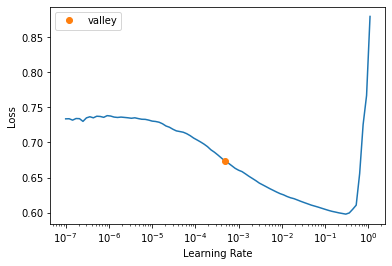

In [14]:
learn.lr_find()

From this curve we can see that the loss hits a minimum around a learning rate of $3 \times 10^{-1}$, so we should select a learning rate lower than this point. The `lr_find()` method provides a handy heuristic to pick the learning rate 1-2 orders of magnitude less than the minimum, as indicated by the orange dot. 

### Train your model

In the above learning rate plot, it appears a learning rate of around $10^{-3}$ would be good, so let's choose that and train our models for 3 epochs:

In [25]:
learn.fit_one_cycle(n_epoch=3, lr_max=1e-3)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.519512,0.515246,0.728947,0.802861,00:17
1,0.428372,0.412589,0.805438,0.885984,00:17
2,0.383711,0.377635,0.827349,0.905258,00:17


Once the model is trained, we can view the results in various ways. A simple approach is to use the `show_results()` method to compare the model errors:

In [21]:
learn.show_results()

,E_0,PX_0,PY_0,PZ_0,E_1,PX_1,PY_1,PZ_1,E_2,PX_2,PY_2,PZ_2,E_3,PX_3,PY_3,PZ_3,E_4,PX_4,PY_4,PZ_4,E_5,PX_5,PY_5,PZ_5,E_6,PX_6,PY_6,PZ_6,E_7,PX_7,PY_7,PZ_7,E_8,PX_8,PY_8,PZ_8,E_9,PX_9,PY_9,PZ_9,E_10,PX_10,PY_10,PZ_10,E_11,PX_11,PY_11,PZ_11,E_12,PX_12,PY_12,PZ_12,E_13,PX_13,PY_13,PZ_13,E_14,PX_14,PY_14,PZ_14,E_15,PX_15,PY_15,PZ_15,E_16,PX_16,PY_16,PZ_16,E_17,PX_17,PY_17,PZ_17,E_18,PX_18,PY_18,PZ_18,E_19,PX_19,PY_19,PZ_19,E_20,PX_20,PY_20,PZ_20,E_21,PX_21,PY_21,PZ_21,E_22,PX_22,PY_22,PZ_22,E_23,PX_23,PY_23,PZ_23,E_24,PX_24,PY_24,PZ_24,E_25,PX_25,PY_25,PZ_25,E_26,PX_26,PY_26,PZ_26,E_27,PX_27,PY_27,PZ_27,E_28,PX_28,PY_28,PZ_28,E_29,PX_29,PY_29,PZ_29,E_30,PX_30,PY_30,PZ_30,E_31,PX_31,PY_31,PZ_31,E_32,PX_32,PY_32,PZ_32,E_33,PX_33,PY_33,PZ_33,E_34,PX_34,PY_34,PZ_34,E_35,PX_35,PY_35,PZ_35,E_36,PX_36,PY_36,PZ_36,E_37,PX_37,PY_37,PZ_37,E_38,PX_38,PY_38,PZ_38,E_39,PX_39,PY_39,PZ_39,E_40,PX_40,PY_40,PZ_40,E_41,PX_41,PY_41,PZ_41,E_42,PX_42,PY_42,PZ_42,E_43,PX_43,PY_43,PZ_43,E_44,PX_44,PY_44,PZ_44,E_45,PX_45,PY_45,PZ_45,E_46,PX_46,PY_46,PZ_46,E_47,PX_47,PY_47,PZ_47,E_48,PX_48,PY_48,PZ_48,E_49,PX_49,PY_49,PZ_49,E_50,PX_50,PY_50,PZ_50,E_51,PX_51,PY_51,PZ_51,E_52,PX_52,PY_52,PZ_52,E_53,PX_53,PY_53,PZ_53,E_54,PX_54,PY_54,PZ_54,E_55,PX_55,PY_55,PZ_55,E_56,PX_56,PY_56,PZ_56,E_57,PX_57,PY_57,PZ_57,E_58,PX_58,PY_58,PZ_58,E_59,PX_59,PY_59,PZ_59,E_60,PX_60,PY_60,PZ_60,E_61,PX_61,PY_61,PZ_61,E_62,PX_62,PY_62,PZ_62,E_63,PX_63,PY_63,PZ_63,E_64,PX_64,PY_64,PZ_64,E_65,PX_65,PY_65,PZ_65,E_66,PX_66,PY_66,PZ_66,E_67,PX_67,PY_67,PZ_67,E_68,PX_68,PY_68,PZ_68,E_69,PX_69,PY_69,PZ_69,E_70,PX_70,PY_70,PZ_70,E_71,PX_71,PY_71,PZ_71,E_72,PX_72,PY_72,PZ_72,E_73,PX_73,PY_73,PZ_73,E_74,PX_74,PY_74,PZ_74,E_75,PX_75,PY_75,PZ_75,E_76,PX_76,PY_76,PZ_76,E_77,PX_77,PY_77,PZ_77,E_78,PX_78,PY_78,PZ_78,E_79,PX_79,PY_79,PZ_79,E_80,PX_80,PY_80,PZ_80,E_81,PX_81,PY_81,PZ_81,E_82,PX_82,PY_82,PZ_82,E_83,PX_83,PY_83,PZ_83,E_84,PX_84,PY_84,PZ_84,E_85,PX_85,PY_85,PZ_85,E_86,PX_86,PY_86,PZ_86,E_87,PX_87,PY_87,PZ_87,E_88,PX_88,PY_88,PZ_88,E_89,PX_89,PY_89,PZ_89,E_90,PX_90,PY_90,PZ_90,E_91,PX_91,PY_91,PZ_91,E_92,PX_92,PY_92,PZ_92,E_93,PX_93,PY_93,PZ_93,E_94,PX_94,PY_94,PZ_94,E_95,PX_95,PY_95,PZ_95,E_96,PX_96,PY_96,PZ_96,E_97,PX_97,PY_97,PZ_97,E_98,PX_98,PY_98,PZ_98,E_99,PX_99,PY_99,PZ_99,E_100,PX_100,PY_100,PZ_100,E_101,PX_101,PY_101,PZ_101,E_102,PX_102,PY_102,PZ_102,E_103,PX_103,PY_103,PZ_103,E_104,PX_104,PY_104,PZ_104,E_105,PX_105,PY_105,PZ_105,E_106,PX_106,PY_106,PZ_106,E_107,PX_107,PY_107,PZ_107,E_108,PX_108,PY_108,PZ_108,E_109,PX_109,PY_109,PZ_109,E_110,PX_110,PY_110,PZ_110,E_111,PX_111,PY_111,PZ_111,E_112,PX_112,PY_112,PZ_112,E_113,PX_113,PY_113,PZ_113,E_114,PX_114,PY_114,PZ_114,E_115,PX_115,PY_115,PZ_115,E_116,PX_116,PY_116,PZ_116,E_117,PX_117,PY_117,PZ_117,E_118,PX_118,PY_118,PZ_118,E_119,PX_119,PY_119,PZ_119,E_120,PX_120,PY_120,PZ_120,E_121,PX_121,PY_121,PZ_121,E_122,PX_122,PY_122,PZ_122,E_123,PX_123,PY_123,PZ_123,E_124,PX_124,PY_124,PZ_124,E_125,PX_125,PY_125,PZ_125,E_126,PX_126,PY_126,PZ_126,E_127,PX_127,PY_127,PZ_127,E_128,PX_128,PY_128,PZ_128,E_129,PX_129,PY_129,PZ_129,E_130,PX_130,PY_130,PZ_130,E_131,PX_131,PY_131,PZ_131,E_132,PX_132,PY_132,PZ_132,E_133,PX_133,PY_133,PZ_133,E_134,PX_134,PY_134,PZ_134,E_135,PX_135,PY_135,PZ_135,E_136,PX_136,PY_136,PZ_136,E_137,PX_137,PY_137,PZ_137,E_138,PX_138,PY_138,PZ_138,E_139,PX_139,PY_139,PZ_139,E_140,PX_140,PY_140,PZ_140,E_141,PX_141,PY_141,PZ_141,E_142,PX_142,PY_142,PZ_142,E_143,PX_143,PY_143,PZ_143,E_144,PX_144,PY_144,PZ_144,E_145,PX_145,PY_145,PZ_145,E_146,PX_146,PY_146,PZ_146,E_147,PX_147,PY_147,PZ_147,E_148,PX_148,PY_148,PZ_148,E_149,PX_149,PY_149,PZ_149,E_150,PX_150,PY_150,PZ_150,E_151,PX_151,PY_151,PZ_151,E_152,PX_152,PY_152,PZ_152,E_153,PX_153,PY_153,PZ_153,E_154,PX_154,PY_154,PZ_154,E_155,PX_155,PY_155,PZ_155,E_156,PX_156,PY_156,PZ_156,E_157,PX_157,PY_157,PZ_157,E_158,PX_158,PY_158,PZ_158,E_159,PX_159,PY_159,PZ_159,E_160,PX_160,PY_160,PZ_160,E_161,PX_161,PY_161,PZ_161,E_162,PX_162,PY_162,PZ_162,E_163,PX_163,PY_163,PZ_163,E_164,PX_16

Here we can see that model made a handful of errors, which is expected since our accuracy is only around 82%. However, evaluating our model’s predictions on the same data it was trained on is almost always a recipe for disaster! Why? The problem is that the model may memorise the structure of the data it sees and fail to provide good predictions when shown new data. Let's see how we can evaluate our model on examples from the _test set_ that it has never seen.

### Evaluate your model

The learners in fastai are equipped with `predict()` and `get_preds()` methods that allow one to evaluae the model on new data. To use them, we'll need a new `DataLoader` which we can create by simply passing in a `DataFrame` of the test events:

In [26]:
test_df = top_quark_ds["test"].to_pandas()
test_dl = learn.dls.test_dl(test_items=test_df)

Now that we have a `DataLoader`, it's a simple matter to compute the predictions with the `get_preds()` method:

In [27]:
preds, targs = learn.get_preds(dl=test_dl)

Let's take a look at the first few values of `preds` and `targs`:

In [28]:
preds[:5], targs[:5]

(tensor([[9.9955e-01, 4.5025e-04],
         [5.7831e-01, 4.2169e-01],
         [9.4110e-01, 5.8897e-02],
         [4.0278e-01, 5.9722e-01],
         [9.7861e-01, 2.1394e-02]]),
 tensor([[0],
         [0],
         [0],
         [0],
         [0]], dtype=torch.int8))

Here we can see that they are _tensors_. In PyTorch, a tensor is similar to the arrays that you may be familiar with in Numpy. Tensors have a rank that can be inspected by using the `size()` method:

In [18]:
preds.size(), targs.size()

(torch.Size([404000, 2]), torch.Size([404000, 1]))

In this case, we see that `preds` is a rank-2 tensor (i.e. a matrix), while `targs` is rank-1 (a vector). Note that each dimension in `preds` corresponds to the _probabilities_ of the model for the two classes (signal vs background). We can visualise the distribution of the probabilities for each class by filtering the `preds` tensor according to the ground truch labels and then plotting the result as a histogram:

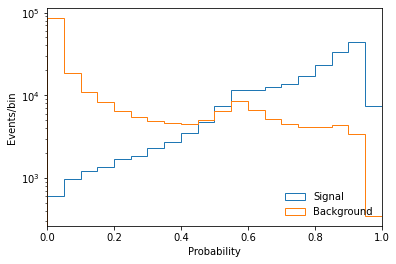

In [31]:
signal_test = preds[:, 1][targs.flatten() == 1].numpy()
background_test = preds[:, 1][targs.flatten() == 0].numpy()

plt.hist(signal_test, histtype="step", bins=20, range=(0, 1), label="Signal")
plt.hist(background_test, histtype="step", bins=20, range=(0, 1), label="Background")
plt.xlabel("Probability")
plt.ylabel("Events/bin")
plt.yscale("log")
plt.xlim(0, 1)
plt.legend(loc="lower right", frameon=False)
plt.show()

We see that although the model assigns high (low) probabilities to the signal (background) events, a fair amount of the signal events overlap with background ones.  To handle this, one usually defines a "cut" or threshold that only includes events above that value. For example, if define the cut at 0, then all the events are counted and the signal efficiency $\epsilon_S$ and background efficiency $\epsilon_B$ are both 1. As we increase the cut, we reject more and more background events and the result is a curve with $\epsilon_{B,S}$ ranging from 0 to 1. 

This curve is equivalent to the Reciever Operating Characteristic (ROC) curve which plots the true positive rate

$$ \mathrm{TPR} = \frac{\mathrm{TP}}{\mathrm{TP} + \mathrm{FP}} \,, \qquad \mathrm{TP\, (FP)} = \mathrm{number\, of\, true\, (false) \,positives}\,, $$

against the false positive rate FPR, where the FPR is the ratio of negative instances that are incorrectly classified as positive. In general there is a tradeoff between these two quantities: the higher the TPR, the more false positives (FPR) the classifier produces.

To visualise the ROC curve for our model's predictions, we can use the handy `roc_curve()` function from scikit-learn:

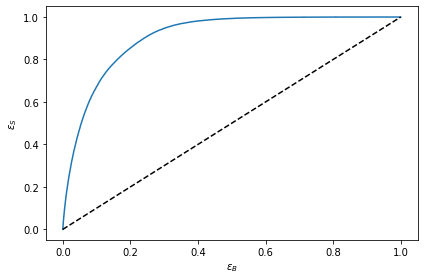

In [40]:
# fpr = epsilon_B, tpr = epsilon_S
fpr, tpr, thresholds = roc_curve(y_true=targs, y_score=preds[:, 1])

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], ls="--", color="k")
plt.xlabel(r"$\epsilon_B$")
plt.ylabel(r"$\epsilon_S$")
plt.tight_layout()

A perfect classifier would have a ROC curve with all signal and background events correctly identified, i.e. an Area Under the Curve (AUC) of 1. Let's compute this area along with the accuracy on the test set:

In [38]:
acc_test = accuracy_score(targs, preds.argmax(dim=-1))
auc_test = auc(fpr, tpr)
print(f"Accuracy: {acc_test:.4f}")
print(f"AUC: {auc_test:.4f}")

Accuracy: 0.8298
AUC: 0.9067


Since the AUC is dominated by values at large $\epsilon_B$, it is common to also report the background rejection at a fixed signal efficiency (often 30%). We can do that by defining an interpolating function across the `tpr` and `fpr` values as follows:

In [41]:
background_eff = interp1d(tpr, fpr)
background_eff_at_30 = background_eff(0.3)
print(f"Backround rejection at signal efficiency 0.3: {1/background_eff_at_30:0.3f}")

Backround rejection at signal efficiency 0.3: 41.597


Comparing these results again the [_The Machine Learning Landscape of Top Taggers_](https://arxiv.org/abs/1902.09914) review, shows that our baseline model falls short of the models in the review, which get a typical accuracy of 93% and an AUC of 98%. 

```{figure} ./images/top-tagging-scores.png
---
scale: 25%
name: top-landscape
---
Figure reference: [The Machine Learning Landscape of Top Taggers](https://arxiv.org/abs/1902.09914)
```

Let's see if we can train a better model by choosing a clever representation of the input data! Before doing that, let's collect this evaluation logic in a function that we can reuse later:

In [42]:
def compute_metrics(learn, test_df):
    test_dl = learn.dls.test_dl(test_items=test_df)
    preds, targs = learn.get_preds(dl=test_dl)
    fpr, tpr, _ = roc_curve(y_true=targs, y_score=preds[:, 1])
    acc_test = accuracy_score(targs, preds.argmax(dim=-1))
    auc_test = auc(fpr, tpr)
    background_eff = interp1d(tpr, fpr)
    background_eff_at_30 = background_eff(0.3)

    print(f"Accuracy: {acc_test:.4f}")
    print(f"AUC: {auc_test:.4f}")
    print(
        f"Backround rejection at signal efficiency 0.3: {1/background_eff_at_30:0.3f}"
    )
    return fpr, tpr

In [43]:
fpr_baseline, tpr_baseline = compute_metrics(learn, test_df)

Accuracy: 0.8298
AUC: 0.9067
Backround rejection at signal efficiency 0.3: 41.597


## Jet representations

In any machine learning problem, how we represent the data often has a large impact on the performance of the models we train. For jet tagging, the most common approaches one finds in the literature include:

* **Jets as images.** A jet image is a pixelated grayscale image, where the pixel intensity represents the energy (or transverse momentum) of all particles that deposited energy in a particular location in the $\eta-\phi$ plane. Typically, _convolutional neural networks (CNNs)_ are used to process the images and we'll ecplore these architectures in a future lesson.
* **Jets as sequences.** Here the idea is to order the particles in a jet (usually by $p_T$) and use sequence-based architectures like _recurrent neural networks (RNNs)._
* **Jets as graphs.** This approach treats each jet as a generic graph of nodes and edges. Graph neural networks (which we'll also encounter later in the course) excel on this tpe of data.
* **Jets as sets.** A generalisation of the previous representations, this approach simply treats each jets as an unordered collection or point cloud of 4-vectors.
* **Theory-inspired representations.** Instead of representing the jets in formats to match specific neural network architectures, these approaches use results on IR safety from QCD to represent the jets as a simplified set of features. Fully-connected neural networks are then trained on these features.

You can find more details about each representation in a nice [review article](https://arxiv.org/abs/1709.04464) from 2017. 

```{figure} ./images/jets.png
---
scale: 40%
name: jet-substructure
---
Figure reference: [Jet Substructure at the Large Hadron Collider](https://arxiv.org/abs/1709.04464)
```

In this lesson and the next, we'll use one of the theory-inspired representations called $N$-subjettiness. Let's take a look.

### Representing jets with $N$-subjettiness observables

$N$-subjettiness observables quantify how much of the radiation in a jet is aligned along different subjet axes. Although originally used for analytic approaches to distinguish different decays and event topologies, these observable can also be used as inputs for machine learning models and provide strong discriminating power. 

To be precise, an $N$-subjettiness observable $\tau_N^{(\beta)}$ measures the radiation about $N$ axes in the jet according to an angular exponent $\beta>0$:

$$ \tau_N^{(\beta)} = \frac{1}{p_{T,J}} \sum_{i\in J} p_{T,i} \min \left\{ R_{1,i}^\beta, R_{1,i}^\beta, \ldots , R_{1,i}^\beta \right\} $$

Here $p_{T,J}$ is the transverse momentum of the jet, $p_{T,i}$ is the transverse momentum of particle $i$ in the jet, and $R_{K,i}$ is the distance in the $\eta-\phi$ plane of particle $i$ to axis $K$.

To measure substructure in a jet, one thus needs to measure a suitable number of $N$-subjettiness observables. In practice this is done by specifying the corrdinates of $M$-body phase space in terms of $3M - 4$ $N$-subjettiness observables:

$$ \left\{ \tau_1^{(0.5)}, \tau_1^{(1)}, \tau_1^{(2)}, \tau_2^{(0.5)}, \tau_2^{(1)}, \tau_2^{(2)}, \ldots , \tau_{m-1}^{(0.5)}, \tau_{m-1}^{(1)}, \tau_{m-1}^{(2)} \right\} $$

To see how we can use this basis as features for a neural network, we have computed $N$-subjettiness observables up through 6-body phase space using the [pyjet library](https://github.com/scikit-hep/pyjet). You can download these features via the `load_dataset()` function as follows:

In [44]:
nsubjet_ds = load_dataset("top-landscape/nsubjettiness")

  0%|          | 0/3 [00:00<?, ?it/s]

As before, we'll convert our `Dataset` object to a pandas `DataFrame`:

In [45]:
train_df = nsubjet_ds["train"].to_pandas()
train_df.head()

,pT,mass,tau_1_0.5,tau_1_1,tau_1_2,tau_2_0.5,tau_2_1,tau_2_2,tau_3_0.5,tau_3_1,...,tau_4_0.5,tau_4_1,tau_4_2,tau_5_0.5,tau_5_1,tau_5_2,tau_6_0.5,tau_6_1,tau_6_2,label
0,543.633944,25.846792,0.165122,0.032661,0.002262,0.048830,0.003711,0.000044,0.030994,0.001630,...,0.024336,0.001115,0.000008,0.004252,0.000234,7.706005e-07,0.000000,0.000000,0.000000e+00,0
1,452.411860,13.388679,0.162938,0.027598,0.000876,0.095902,0.015461,0.000506,0.079750,0.009733,...,0.056854,0.005454,0.000072,0.044211,0.004430,6.175314e-05,0.037458,0.003396,3.670517e-05,0
2,429.495258,32.021091,0.244436,0.065901,0.005557,0.155202,0.038807,0.002762,0.123285,0.025339,...,0.078205,0.012678,0.000567,0.052374,0.005935,9.395772e-05,0.037572,0.002932,2.237277e-05,0
3,512.675443,6.684734,0.102580,0.011369,0.000170,0.086306,0.007760,0.000071,0.068169,0.005386,...,0.044705,0.002376,0.000008,0.027895,0.001364,4.400042e-06,0.009012,0.000379,6.731099e-07,0
4,527.956859,133.985415,0.407009,0.191839,0.065169,0.291460,0.105479,0.029753,0.209341,0.049187,...,0.143768,0.033249,0.003689,0.135407,0.029054,2.593460e-03,0.110805,0.023179,2.202088e-03,0


Following Section 3.2.2 of [_The Machine Learning Landscape of Top Taggers_](https://arxiv.org/abs/1902.09914) revie, we've also included the jet mass and jet $p_T$ as input variables to allow the network to learn physical scales. 

Let's now train a model using these features. As before, we need to first define our `DataLoaders` object:

In [ ]:
features = list(train_df.drop(columns=["label"]).columns)
splits = RandomSplitter(valid_pct=0.20, seed=42)(range_of(train_df))

dls = TabularDataLoaders.from_df(
    df=train_df,
    cont_names=features,
    y_names="label",
    y_block=CategoryBlock,
    splits=splits,
    bs=1024,
)

And just like before it's a good idea to sanity check your data is formatted correctly with the `show_batch()` method:

In [58]:
dls.show_batch()

,pT,mass,tau_1_0.5,tau_1_1,tau_1_2,tau_2_0.5,tau_2_1,tau_2_2,tau_3_0.5,tau_3_1,tau_3_2,tau_4_0.5,tau_4_1,tau_4_2,tau_5_0.5,tau_5_1,tau_5_2,tau_6_0.5,tau_6_1,tau_6_2,label
0,522.048523,92.153114,0.380715,0.152588,0.030916,0.209502,0.063390,0.012665,0.128889,0.022069,0.001222,0.080150,0.008402,0.000132,0.062777,0.005676,0.000066,0.061174,0.005158,0.000047,1
1,490.363983,16.609573,0.142445,0.024298,0.001147,0.125517,0.017618,0.000510,0.106961,0.014460,0.000437,0.075176,0.010565,0.000377,0.067740,0.008125,0.000184,0.060120,0.006607,0.000133,0
2,597.580627,11.862260,0.102949,0.012941,0.000394,0.028407,0.001140,0.000004,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
3,410.707581,110.755287,0.464703,0.231042,0.071603,0.362819,0.144754,0.030714,0.207168,0.049700,0.005184,0.179310,0.039279,0.004393,0.140951,0.021013,0.000512,0.105367,0.013844,0.000260,1
4,492.455933,88.497200,0.273165,0.096267,0.032805,0.161123,0.036006,0.004653,0.137017,0.028750,0.003992,0.131875,0.025842,0.003297,0.102738,0.016257,0.000792,0.089491,0.014246,0.000685,0
5,486.640076,82.906929,0.374259,0.149829,0.028759,0.195415,0.043984,0.003262,0.149471,0.028019,0.001442,0.124134,0.018277,0.000586,0.089580,0.011080,0.000263,0.081060,0.009292,0.000190,0
6,498.425018,74.020676,0.319596,0.113914,0.022166,0.194463,0.045124,0.004859,0.126797,0.029602,0.004256,0.092667,0.012628,0.000443,0.081185,0.009410,0.000207,0.069710,0.007587,0.000152,0
7,482.718689,137.798355,0.534312,0.282997,0.080556,0.223277,0.057922,0.005523,0.168434,0.031699,0.001601,0.096233,0.019055,0.000967,0.062624,0.011516,0.000551,0.050928,0.007994,0.000340,1
8,460.214264,86.461731,0.394985,0.164138,0.034991,0.196663,0.051140,0.008192,0.151665,0.029648,0.002539,0.119369,0.018011,0.000727,0.108922,0.014594,0.000401,0.081296,0.010506,0.000320,1
9,421.069519,130.139618,0.541720,0.292501,0.094090,0.264684,0.073185,0.007385,0.237238,0.060748,0.006059,0.171330,0.040395,0.004234,0.155388,0.033190,0.003280,0.096977,0.015955,0.000639,1


This looks good, so the last step is to create a `Learner` and find a good learning rate:

SuggestedLRs(valley=0.0006918309954926372)

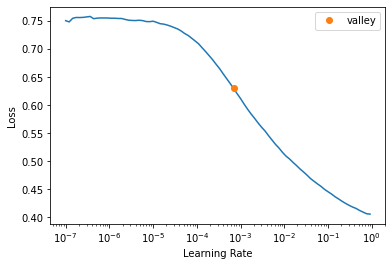

In [59]:
learn = tabular_learner(
    dls, layers=[200, 200, 50, 50], metrics=[accuracy, RocAucBinary()]
)

learn.lr_find()

This curve is similar to what we found before so let's pick a learning rate of $10^{-3}$ and train for 3 epochs:

In [61]:
learn.fit_one_cycle(n_epoch=3, lr_max=1e-3)

epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.231049,0.233586,0.901305,0.965739,00:08
1,0.225276,0.222848,0.905830,0.968632,00:08
2,0.223792,0.231189,0.901206,0.967666,00:08


We can already see that training on the $N$-subjettiness features has produced a better model than our baseline, which achieved around 83% and $91%$ accuracy and AUC score respectively. Let's wrap up by computing these metrics on the test set with our `compute_metrics()` function:

In [62]:
test_df = nsubjet_ds["test"].to_pandas()
fpr_nsubjet, tpr_nsubjet = compute_metrics(learn, test_df)

Accuracy: 0.9006
AUC: 0.9671
Backround rejection at signal efficiency 0.3: 348.128


This is much better and now just a 1-2% the classifiers reported in the review paper! We can also compare both models by plotting the background rejection rate against the signal efficiency:

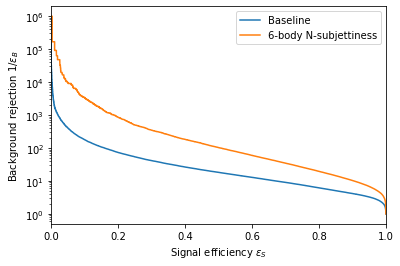

In [63]:
fig, ax = plt.subplots()

plt.plot(tpr_baseline, 1 / (fpr_baseline + 1e-6), label="Baseline")
plt.plot(tpr_nsubjet, 1 / (fpr_nsubjet + 1e-6), label="6-body N-subjettiness")
plt.xlabel("Signal befficiency $\epsilon_{S}$")
plt.ylabel("Background rejection $1/\epsilon_{B}$")
plt.xlim(0, 1)
plt.yscale("log")
plt.legend()
plt.show()

## Exercises

* Try changing the network architecture by adjusting the `layers` argument in `tabular_learner()` on the $N$-subjettiness features. What happens if you keep the number of nodes fixed and increase the number of layers? Similarly, what happens if you have just a single layer, but increase the number of nodes on that layer?
* Train a model on the $N$-subjettiness features without including the jet mass and $p_T$. Does this have a positive or negative impact on performance?
* Train a model using 2-body and 4-body $N$-subjettiness features to see if the performance is saturated with a smaller number of features.